## **Prediction of the Titanic Survivors**

In this analysis we are going to predict who has survived on Titanic tragedy.

**The dataset** can be found at Kaggle (https://www.kaggle.com/c/titanic/data) and contains data about information on Titanic's cruise passengers. It consists of the following features:

- **PassengerId** - A numerical id assigned to each passenger;
- **Survived** - Whether the passenger survived (1), or didn't (0). It is ours **target variable**;
- **Pclass** - Ticket class (1st = Upper, 2nd = Middle, 3rd = Lower);
- **Name** - The name of the passenger;
- **Sex** - The gender of the passenger (male or female);
- **Age** - The age of the passenger;
- **SibSp** - number of siblings (brother, sister, stepbrother, stepsister) / spouses (husband, wife [mistresses and fiancés were ignored]) aboard the Titanic;
- **Parch** - number of parents (mother, father) / children (daughter, son, stepdaughter, stepson) aboard the Titanic. Note: Some children travelled only with a nanny, therefore parch=0 for them;
- **Ticket** - The ticket number of the passenger;
- **Fare** - How much the passenger paid for the ticker;
- **Cabin** - Cabin number;
- **Embarked** - Where the passenger boarded the Titanic Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

###Importing some usefull libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno
#we do not want to see any warnings
import warnings
warnings.filterwarnings('ignore')

# sklearn models to test
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

#xgboost model
from xgboost import XGBClassifier


### Loading the dataset

In [2]:
cd "/content/drive/My Drive/Colab Notebooks/titanic"

/content/drive/My Drive/Colab Notebooks/titanic


In [3]:
ls

titanic.csv


###Some preliminary information about analyzed dataset

In [4]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We want to find out more about the exact numerical statistics of the distribution of analyzed dataset so we use describe() method:


In [7]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#shape of data
titanic.shape

(891, 12)

In [10]:
#we check how many missing values are:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are three variables with missing values i.e. Age, Cabin and Embarked, so let's try to visualize them.

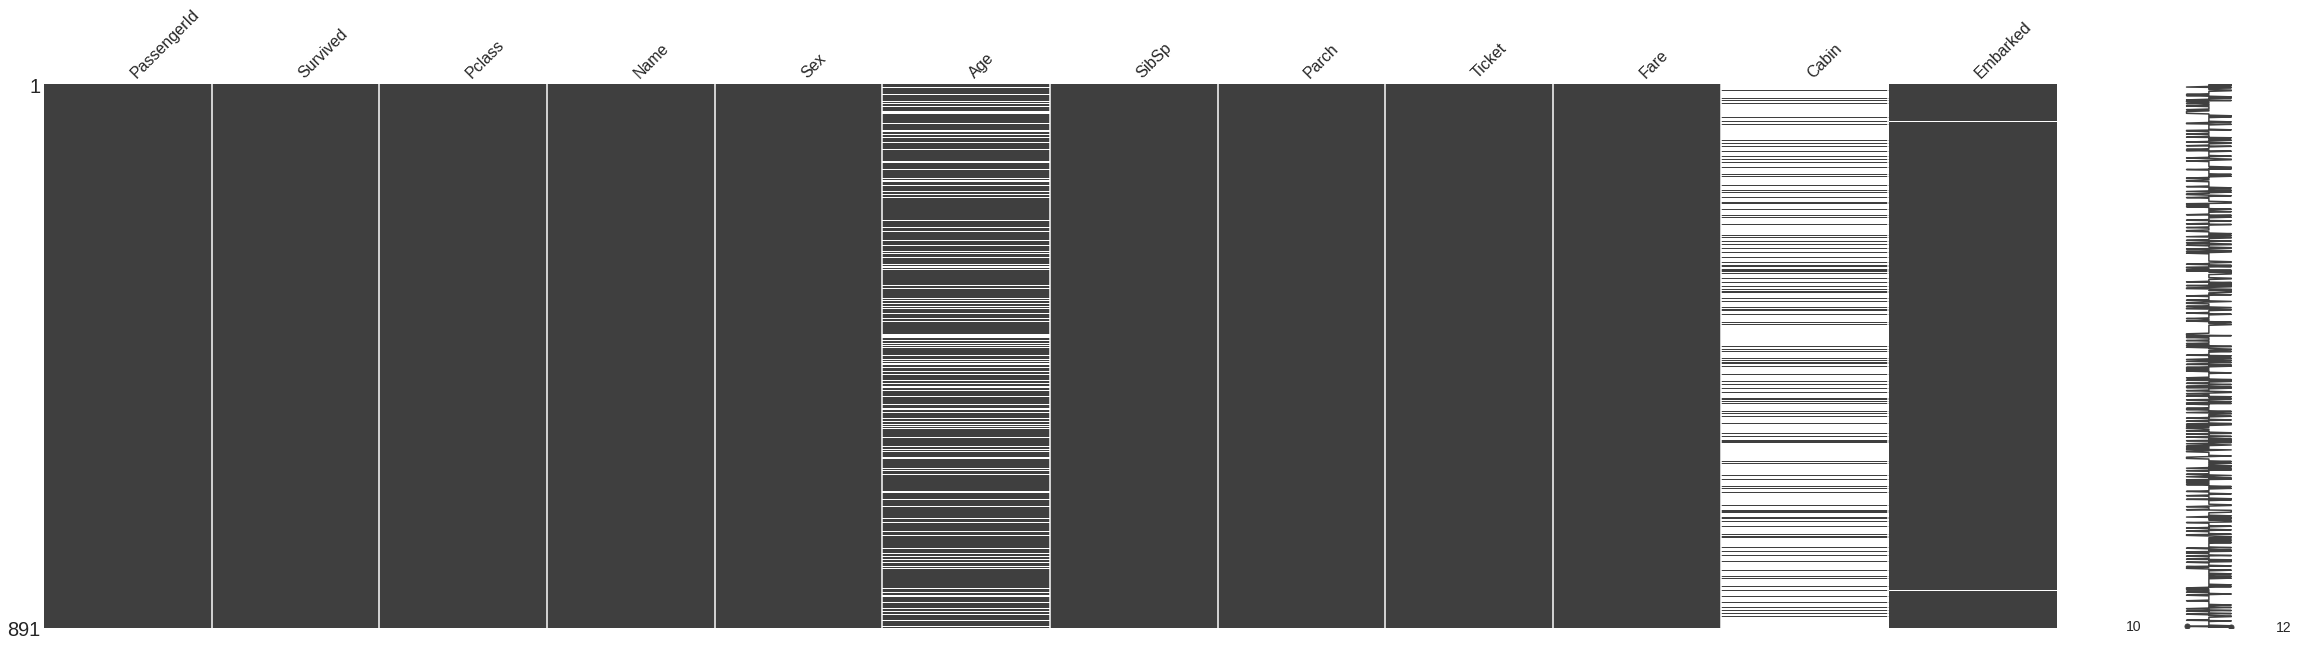

In [11]:
# Plot graphic of missing values
missingno.matrix(titanic, figsize = (40,10));

Since Age and the place of Embarkation will be important in further analysis so firstly we take a look at the distribution of the Age column to see if it's skewed or symmetrical. This trick allows us to determine what value is crucial to replace the NaN values.


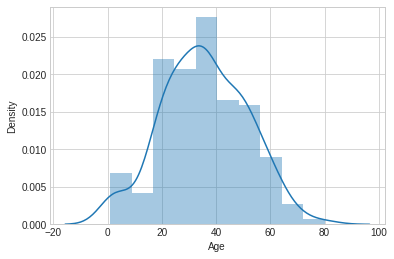

In [12]:
#distribution of the Age:
copy = titanic.copy()
copy.dropna(inplace = True)
sns.distplot(copy["Age"]);

The plot of Age column shows that the distribution of ages is slightly skewed right. In this regards the most accuracy will be given if we fill in the null values with the median one.


Secondly we take a look at the distribution of the Embarked column to see what value is crucial to replace the NaN values.

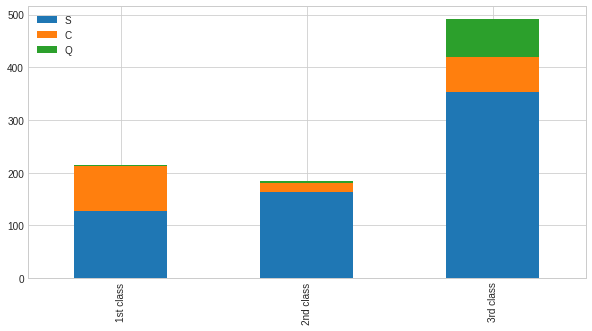

In [13]:
Pclass1 = titanic[titanic['Pclass']==1]['Embarked'].value_counts()
Pclass2 = titanic[titanic['Pclass']==2]['Embarked'].value_counts()
Pclass3 = titanic[titanic['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5));

This plot of Embarked column shows that the most accuracy will be given if we replace the null values with the S embark value, because:
- more than 50% of 1st class are from S embark;
- more than 50% of 2nd class are from S embark;
- more than 50% of 3rd class are from S embark.

The median will be an acceptable value to place in the NaN cells for Age column.
The S will be an acceptable value to place in the NaN cells for Embarked column.


In [14]:
titanic["Age"].fillna(titanic["Age"].median(), inplace = True) 
titanic["Embarked"].fillna("S", inplace = True)

titanic.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

The missing values of Cabin column will be ignored since they do not influence much on the further analysis as will be shown in the EDA analysis.

###EDA analysis with plotting and visualizing data

In this part we will check what factors **affect the survival** of Titanic passengers. There are following categorical features:

- **Pclass**;
- **Sex**;
- **SibSp** ( number of siblings and spouse);
- **Parch** ( number of parents and children);
- **Embarked**;
- **Cabin**.

In [15]:
filtr = titanic['Survived']==1
survivors = titanic[filtr] 
print(survivors)

     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
8              9         1       3  ...  11.1333   NaN         S
9             10         1       2  ...  30.0708   NaN         C
..           ...       ...     ...  ...      ...   ...       ...
875          876         1       3  ...   7.2250   NaN         C
879          880         1       1  ...  83.1583   C50         C
880          881         1       2  ...  26.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
889          890         1       1  ...  30.0000  C148         C

[342 rows x 12 columns]


**Histogram Charts** 

Plots for selected categorical features:


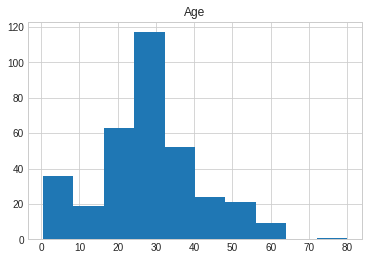

In [16]:
#Histogram of the distribution of survivors:
survivors.hist(column='Age')
plt.show() 

The Chart confirms **young people** (in age between 25 and 32) more likely survived than people in **other ages**.

Since the Titanic sank from the bow of the ship where the third class rooms were located the Pclass is a key feature for analysis:

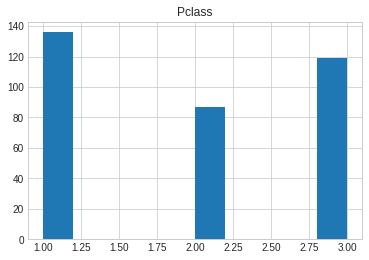

In [17]:
survivors.hist(column='Pclass')
plt.show()

The Chart confirms **1st class** more likely survived than **other classes**.
The Chart confirms **2nd class** more likely dead than **other classes**.

In [18]:
filtr1 = titanic['Survived']==0
dead = titanic[filtr1] 
print(dead)

     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
4              5         0       3  ...   8.0500   NaN         S
5              6         0       3  ...   8.4583   NaN         Q
6              7         0       1  ...  51.8625   E46         S
7              8         0       3  ...  21.0750   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
884          885         0       3  ...   7.0500   NaN         S
885          886         0       3  ...  29.1250   NaN         Q
886          887         0       2  ...  13.0000   NaN         S
888          889         0       3  ...  23.4500   NaN         S
890          891         0       3  ...   7.7500   NaN         Q

[549 rows x 12 columns]


Histogram of the distribution of people who didn't survive:

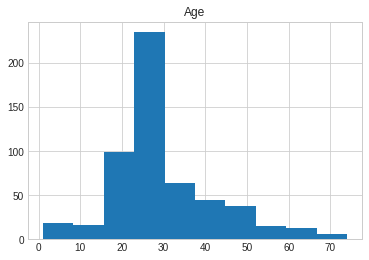

In [19]:
dead.hist(column='Age')
plt.show() 

The Chart confirms **young people** (in age between 25 and 32) more likely dead than people in **other ages**.

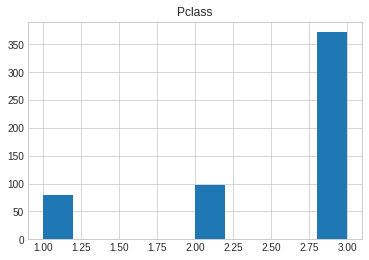

In [20]:
dead.hist(column='Pclass')
plt.show()

The Chart confirms **3rd class** more likely dead than **other classes**.
The Chart confirms **1st and 2nd class** more likely survived than **other classes**.


**Bar Charts** 

Plots for selected categorical features:

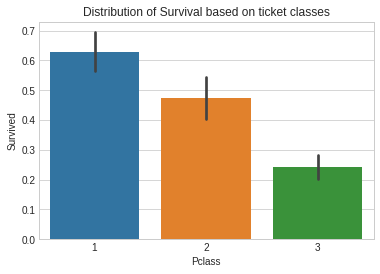

In [21]:
sns.barplot(x="Pclass", y="Survived", data=titanic)
plt.title("Distribution of Survival based on ticket classes")
plt.show()

The Bar Chart confirms **1st class** more likely survived than **other classes**. 
The Chart confirms **3rd class** more likely dead than **other classes**.

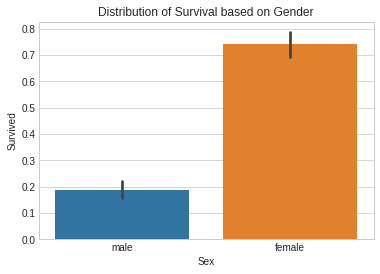

In [22]:
sns.barplot(x="Sex", y="Survived", data=titanic)
plt.title("Distribution of Survival based on Gender")
plt.show()

The Bar Chart confirms **female** more likely survived than **male**.

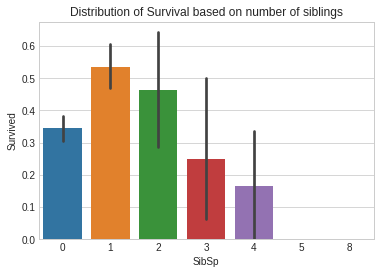

In [23]:
sns.barplot(x="SibSp", y="Survived", data=titanic)
plt.title("Distribution of Survival based on number of siblings")
plt.show()

The Bar Chart confirms a person who travelled **with 1 or 2 siblings or spouse** more likely survived than a person who travelled **with 3 or 4 siblings or spouse.**

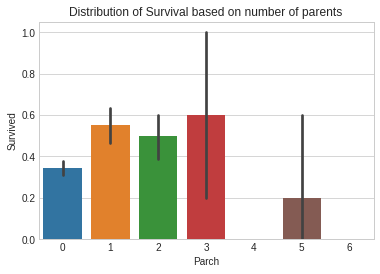

In [24]:
sns.barplot(x="Parch", y="Survived", data=titanic)
plt.title("Distribution of Survival based on number of parents")
plt.show()

The Bar Chart confirms a person who travelled **with more than 1 parents or children** more likely survived than other persons.

**Box and Violin Charts** 

Plots for selected categorical features:

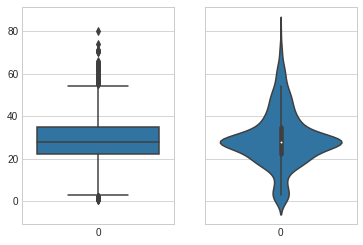

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=titanic['Age'], ax=axes[0]);
sns.violinplot(data=titanic['Age'], ax=axes[1]);

From box and violin plots we see that people above 60 years and below 7 years most likely to dead while people between 22-35 years most likely to survive. Additionally one can see that the violin plot does not contribute any additional information about the data as everything is clear from the box plot alone.


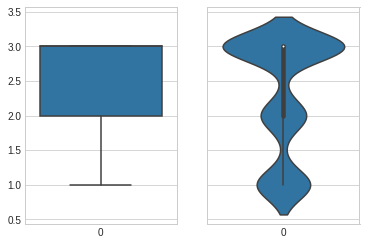

In [25]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=titanic['Pclass'], ax=axes[0]);
sns.violinplot(data=titanic['Pclass'], ax=axes[1]);

The conclusion is the same as in the case of bar plots for these features.

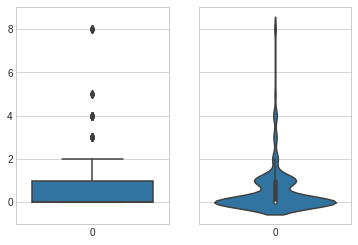

In [26]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=titanic['SibSp'], ax=axes[0]);
sns.violinplot(data=titanic['SibSp'], ax=axes[1]);

The conclusion is the same as in the case of bar plots for these features.


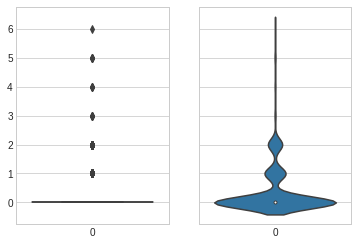

In [27]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=titanic['Parch'], ax=axes[0]);
sns.violinplot(data=titanic['Parch'], ax=axes[1]);

The conclusion is the same as in the case of bar plots for these features.

Now let's try to correlate the survival with the Pclass and Age variables on **swarm and violin plot**.


[Text(0, 0.5, 'Age'),
 Text(0.5, 0, 'Ticket class'),
 Text(0.5, 1.0, 'Survivals for different ticket classes of Titanic')]

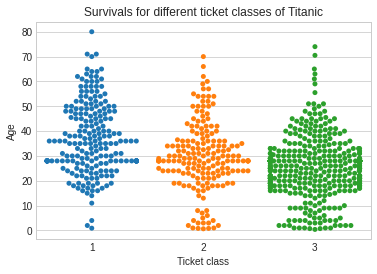

In [28]:
bx = sns.swarmplot(x="Pclass", y="Age", data = titanic);
bx.set(xlabel='Ticket class', ylabel='Age', title='Survivals for different ticket classes of Titanic')

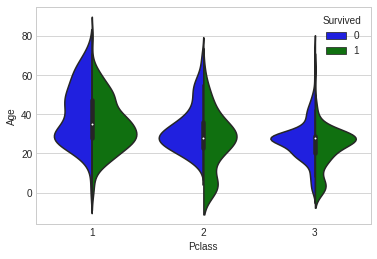

In [29]:
sns.violinplot(x='Pclass', y='Age', 
               hue='Survived', data=titanic, 
               split=True,
               palette={0: "b", 1: "g"}
              );



What we saw in the chart above we may validate by the following:

- in the 1st class survive more elderly people than in remaining ones, as depicted by the larger 1st class green histogram.

Now, we see that the age conditions the survival for Pclass passengers and has a direct impact on it:
- Younger people tend to survive in 2nd and 3rd class;
- A large number of passengers between 20 and 40 succumb in 2nd and 3rd class while in 1st class succumb a large number of passangers between 40 and 60.



Now let's check if and how the embarkation site affects the survival on **box and violin plots.**

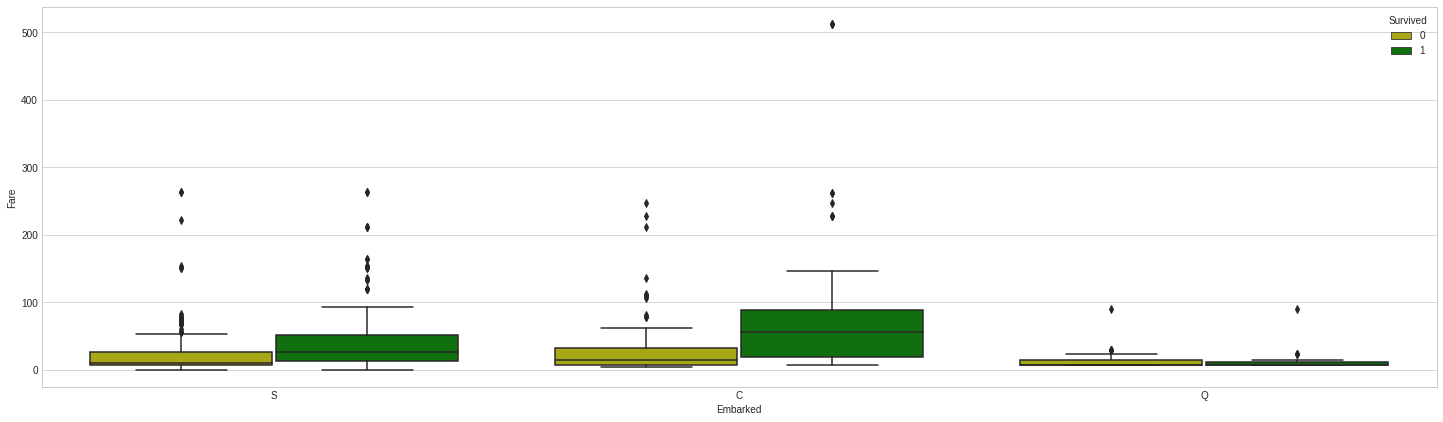

In [30]:
fig = plt.figure(figsize=(25, 7))
sns.boxplot(x='Embarked', y='Fare', hue='Survived', data=titanic, palette={0: "y", 1: "g"});

The box plots confirm as follows:
- **a person aboarded from C** slightly more likely survived;
- **a person aboarded from Q** more likely dead;
- **a person aboarded from S** more likely dead.

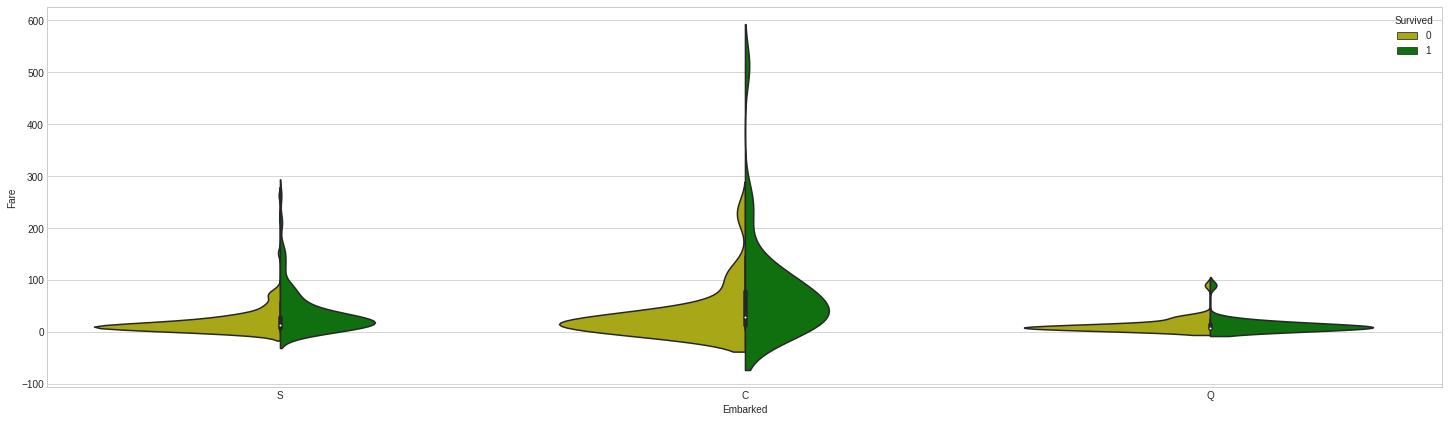

In [31]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=titanic, split=True, palette={0: "y", 1: "g"});

The violin plots confirm the same as box plots above.

To show relations between the all different features we may plot a pairplot of our dataset

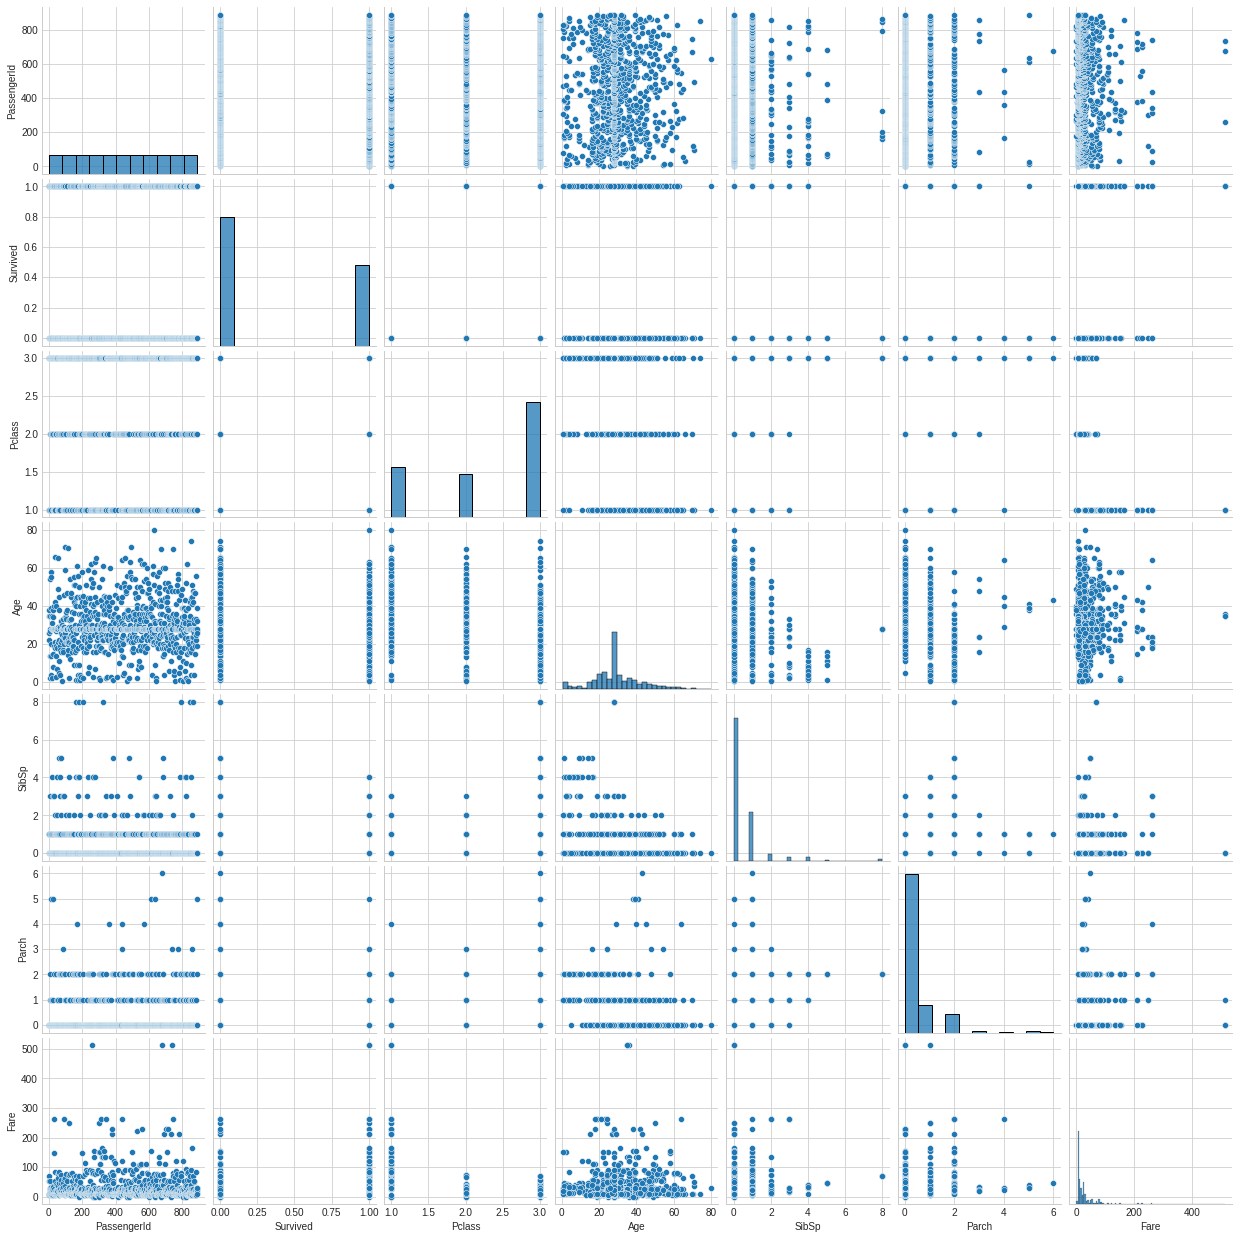

In [32]:
sns.pairplot(titanic);

##**Feature Engineering**

We start with encoding categorical columns of the Sex and Embarked into numerical ones through One-Hot-Encoding. It may allow us to perform classification of our model. 

In [33]:
sex = {'male':0, 'female':1}
titanic['Sex'] = titanic['Sex'].map(sex)

titanic['Sex'] = pd.Categorical(titanic.Sex).codes

embarked = {'C':0,'Q':1,'S':2}
titanic['Embarked'] = titanic['Embarked'].map(embarked)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2


The next step is extraction of some useful information from the Name column, strictly speaking the title of their names like Ms. or Mr. Since we encoded the Sex and Embarked columns we can also extract the Title and encode it mostly to provide a hint as to whether the passenger survived or not.  

In [34]:
titl = r",\s([^ .]+)\.?\s+"

titanic['Title'] =  titanic['Name'].str.extract(titl,expand=True)

title_replacements = {"Mlle": "Other", "Major": "Other", "Col": "Other", "Sir": "Other", "Don": "Other", "Mme": "Other",
          "Jonkheer": "Other", "Lady": "Other", "Capt": "Other", "Countess": "Other", "Ms": "Other", "Dona": "Other", "Rev": "Other", "Dr": "Other"}

titanic.replace({"Title": title_replacements}, inplace=True)

titanic.loc[titanic["Title"] == "Miss", "Title"] = 0
titanic.loc[titanic["Title"] == "Mr", "Title"] = 1
titanic.loc[titanic["Title"] == "Mrs", "Title"] = 2
titanic.loc[titanic["Title"] == "Master", "Title"] = 3
titanic.loc[titanic["Title"] == "Other", "Title"] = 4

titanic['Title'] = pd.Categorical(titanic.Title).codes
titanic.groupby('Title')['Title'].count()

Title
0    182
1    517
2    125
3     40
4     26
5      1
Name: Title, dtype: int64

In [35]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
362,363,0,3,"Barbara, Mrs. (Catherine David)",1,45.0,0,1,2691,14.4542,NaN,0,2
867,868,0,1,"Roebling, Mr. Washington Augustus II",0,31.0,0,0,PC 17590,50.4958,A24,2,1
501,502,0,3,"Canavan, Miss. Mary",1,21.0,0,0,364846,7.7500,NaN,1,0
484,485,1,1,"Bishop, Mr. Dickinson H",0,25.0,1,0,11967,91.0792,B49,0,1
566,567,0,3,"Stoytcheff, Mr. Ilia",0,19.0,0,0,349205,7.8958,NaN,2,1



Next step is to change the Fare column into categorical one, this way it does not affect the model too much.


In [36]:
titanic['Fare'] = preprocessing.scale(titanic[['Fare']]) [:,0]

We create a new column called Family Size which combine SibSp and Parch columns.

In [37]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic['FamilySize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

###**Build the Machine Learning model**

We start with splitting our data into features and target label. Additionally we will have chosen only a particular features which will have the greatest impact on our model.


In [38]:
features = ["Pclass", "Sex", "Age", "Embarked", "Fare", "FamilySize", "Title"]

X = titanic[features] 
y =titanic["Survived"]

Next we split the data into training and testing sets and show the results of the split:


In [39]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)  

print("Training set:", train_X.shape, train_y.shape)
print("Test set:", test_X.shape, test_y.shape)

Training set: (712, 7) (712,)
Test set: (179, 7) (179,)


**Logistic regression model**

In [40]:
lreg_model = LogisticRegression()

lreg_model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predictions


In [41]:
pred_lreg = lreg_model.predict(test_X)
lreg_score = accuracy_score(test_y, pred_lreg)
lreg_score

0.7877094972067039

In [42]:
print(classification_report(test_y, pred_lreg))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.74      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



The classification report tell us about precision, recall and f-score in the given model.


**SVM Model**

In [43]:
svm_model = SVC(kernel='linear') 

svm_model.fit(train_X, train_y)  
pred_svm = svm_model.predict(test_X)

svm_score = accuracy_score(test_y, pred_svm)
svm_score

0.7877094972067039

In [44]:
print(classification_report(test_y, pred_svm))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       105
           1       0.76      0.70      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



The classification report tell us about precision, recall and f-score in the given model.


**KNN model**

In [45]:
Knn = KNeighborsClassifier(n_neighbors = 3) 

Knn.fit(train_X, train_y)  
pred_knn = Knn.predict(test_X)

acc_knn = accuracy_score(test_y, pred_knn)
acc_knn

0.7541899441340782

In [46]:
print(classification_report(test_y, pred_knn))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       105
           1       0.71      0.68      0.69        74

    accuracy                           0.75       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



The classification report tell us about precision, recall and f-score in the given model.


**Gaussian Naive Bayes model**

In [47]:
gaussianNB_model = GaussianNB() 

gaussianNB_model.fit(train_X, train_y)  
pred_NB = gaussianNB_model.predict(test_X)

acc_gaussianNB = accuracy_score(test_y, pred_NB)
acc_gaussianNB

0.770949720670391

In [48]:
print(classification_report(test_y, pred_NB))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       105
           1       0.70      0.77      0.74        74

    accuracy                           0.77       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.77      0.77       179



The classification report tell us about precision, recall and f-score in the given model.



**Random forest model**



In [49]:
RF_model = RandomForestClassifier(n_estimators=100)

RF_model.fit(train_X, train_y)
pred_RF = RF_model.predict(test_X)

acc_RF = accuracy_score(test_y, pred_RF)
acc_RF

0.8379888268156425

In [50]:
print(classification_report(test_y, pred_RF))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       105
           1       0.80      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



The classification report tell us about precision, recall and f-score in the given model.


**DecisionTree Model**

In [51]:
dt_model = DecisionTreeClassifier()
dt_model.fit(train_X, train_y)
pred_dt = dt_model.predict(test_X)
acc_dt = accuracy_score(test_y, pred_dt)
acc_dt

0.776536312849162

In [52]:
print(classification_report(test_y, pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       105
           1       0.71      0.77      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.78      0.78      0.78       179



The classification report tell us about precision, recall and f-score in the given model.


**XGBoost Model**

In [53]:
xgb_model = XGBClassifier(objective="binary:logistic", n_estimators=10, seed=123)
xgb_model.fit(train_X, train_y)
pred_xg = xgb_model.predict(test_X)
acc_xg = accuracy_score(test_y, pred_xg)
acc_xg

0.8044692737430168

In [54]:
print(classification_report(test_y, pred_xg))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



The classification report tell us about precision, recall and f-score in the given model.


###**Evaluation of the model**

Now we test which model gives the best score:

In [55]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'KNN','Gaussian Naive Bayes', 'Random Forest', 'Decision Tree', 'XGBoost Classifier'],
                      'Score': [lreg_score, svm_score, acc_knn, acc_gaussianNB, acc_RF, acc_dt, acc_xg]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,Random Forest,0.837989
6,XGBoost Classifier,0.804469
0,Logistic Regression,0.787709
1,SVM,0.787709
5,Decision Tree,0.776536
3,Gaussian Naive Bayes,0.770950
2,KNN,0.754190


###**Tuning Parameters with GridSearchCV**

Since the Random Forest model gives the best accuracy we may improve it by turning the hyperparameters. In this regards we will use a GridSearchCV method to find the best parameters for our model and use it to train and test our data.

In [58]:
RF_model = RandomForestClassifier()

parameters = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15], 
              "criterion": ["gini", "entropy"],
              "max_features": ["auto", "sqrt", "log2"], 
              "max_depth": [2, 3, 5, 10], 
              "min_samples_split": [2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 8, 10]
             }

grid_cv = GridSearchCV(RF_model, parameters, scoring = make_scorer(accuracy_score))
grid_cv = grid_cv.fit(train_X, train_y)

print("Our optimized Random Forest model is:")
grid_cv.best_estimator_

Our optimized Random Forest model is:


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
grid_cv.best_score_

0.844085491972816

In [60]:
grid_cv.score(train_X, train_y)

0.8623595505617978

In [61]:
grid_cv.score(test_X, test_y)

0.8156424581005587

##**Conclusions**

In this approach we have investigated the data about information on Titanic's cruise passengers. We have focused in particular on the survivors of the Titanic's tragedy. After examination if our data set has any missing values and checking the features within it and their data types, we begin with the EDA analysis. The bar charts of selected categorical features showed as follows:
- The 1st class more likely survived than other classes and 3rd class more likely dead than other classes;
- The female more likely survived than male;
- A person who travelled with 1 or 2 siblings or spouse more likely survived than a person who travelled with 3 or 4 siblings or spouse;
- A person who travelled with more than 1 parents or children more likely survived than other persons.

While the box and violin plots analysis of selected categorical features showed as follows:
- the age conditions the survival for Pclass passengers and has a direct impact on it;
- Younger people tend to survive in 2nd and 3rd class;
- A large number of passengers between 20 and 40 succumb in 2nd and 3rd class while in 1st class succumb a large number of passangers between 40 and 60;
- the embarkation site affects the survival of particular persons, i.e. a person aboarded from C slightly more likely survived while a person aboarded from Q and S more likely dead.

Additionally one can see that the violin plot does not contribute any additional information about the data as everything is clear from the box plot alone.

Finally we have apllied the ML models to make a predictions who survived the Titanic's tragedy.  Our analysis showed that the best prediction is given by Random Forest model with accuracy score equal to 83 % while the poorest one is given by KNN model with the accuracy score equal to 75 %.

The accuracy given by Random Forest model was then tuned by a GridSearchCV method, reaching the accuracy equal to 86% on train data while for test data it was equal to 81 %.







